# Statistical Learning
1. Use time series methods to forecast with past price.
2. Utilise of traditional language models for sentiment detecting. 
    Include Embedding, tokenising, ...
    - Reference: 
        - [NTU ADL](https://www.csie.ntu.edu.tw/~miulab/s109-adl/)
        - [人工智慧與社會意象](https://drive.google.com/drive/shared-with-me)




## 1. [Time Series](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pmd
import warnings
warnings.filterwarnings("ignore")


In [10]:
# Replace "2409" with the actual stock symbol you are interested in
symbol = "2409.TW"

# Download historical data
data = yf.download(symbol, start="2000-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d")).reset_index()
data["Return"] = (data["Close"].shift(-1) - data["Close"])/data["Close"]
train_window = 20
split_time = pd.Timestamp(2020, 1, 1)
train = data[data["Date"] <= split_time]
test = data[data["Date"] >= split_time]

[*********************100%%**********************]  1 of 1 completed


Return Stationary
Price Nonstationary
(2, 0, 0)


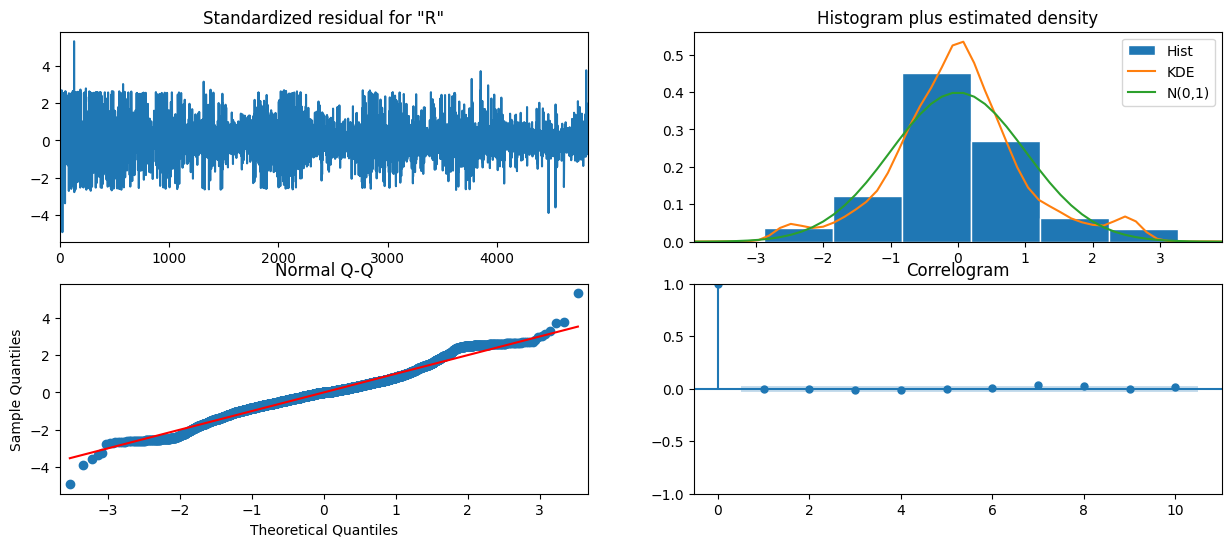

In [13]:
def check_stationality(data):
    s, n, e = 0, 0, 0
    return_pvalue = adfuller(data["Return"])[1]
    
    # 設定判別式以及0.05的P-value標準
    if return_pvalue > 0.05:
        print('Return Nonstationary')
    else:
        print('Return Stationary')
    print("===========================================")
    price_pvalue = adfuller(data["Close"])[1]
    # 設定判別式以及0.05的P-value標準
    if price_pvalue > 0.05:
        print('Price Nonstationary')
    else:
        print('Price Stationary')


def fit_ts(train):
    param = pmd.auto_arima(train["Return"], stationary = True)
    model = ARIMA(train["Return"], order = param.order)
    print(param.order)
    ts = model.fit()
    return ts

check_stationality(train)
ts = fit_ts(train)

ts.summary()
ts.plot_diagnostics(figsize = (15, 6))
plt.show()

In [12]:
data[(data["Date"] <= split_time + pd.Timedelta(days = 10))
                    & (data["Date"] >= split_time - pd.Timedelta(days = 10))]#["Return]

,Date,Open,High,Low,Close,Adj Close,Volume,Return
4826,2019-12-23,12.7500,12.8125,12.5625,12.7500,10.064968,31052668,-0.019608
4827,2019-12-24,12.7500,12.8125,12.5000,12.5000,9.867616,30951820,0.015000
4828,2019-12-25,12.5625,12.8125,12.5625,12.6875,10.015630,49644857,-0.004926
4829,2019-12-26,12.7500,12.8125,12.5625,12.6250,9.966291,18907067,0.004950
4830,2019-12-27,12.6250,13.0625,12.6250,12.6875,10.015630,60419740,-0.004926
4831,2019-12-30,12.6875,12.8125,12.5625,12.6250,9.966291,28064710,-0.004950
4832,2019-12-31,12.6250,12.6875,12.5625,12.5625,9.916954,21239320,0.009950
4833,2020-01-02,12.6875,12.7500,12.6250,12.6875,10.015630,27294720,-0.009852
4834,2020-01-03,12.7500,12.8125,12.3625,12.5625,9.916954,51887718,-0.008955
4835,2020-01-06,12.6250,12.7500,12.3625,12.4500,9.828146,53631657,0.009036


In [ ]:
# test: all test set
# test_: each sample
forecast_step = len(test)
prediction_test = []
real_test = []

for i in range(forecast_step):
    train = data[(data["Date"] >= split_time-pd.Timedelta(days = train_window))
                    & (data["Date"] < split_time)]["Return"]
    test_ = data[(data["Date"] <= split_time + pd.Timedelta(days = 1))
                    & (data["Date"] >= split_time)]["Return"]
    if len(test_) == 0:
        split_time += pd.Timedelta(days = 1)
        continue

    param = pmd.auto_arima(train, stationary = True)
    print(param.order)
    
    model = ARIMA(train, order = param.order)
    ts = model.fit()
    
    forecast = ts.get_forecast(steps=1)
    prediction = forecast.predicted_mean
    confidence = forecast.conf_int

    prediction_test.append(prediction.values[0])
    real_test.append(test_.values[0])
    print(prediction.values[0])
    print(test_.values[0])
    split_time += pd.Timedelta(days = 1)

plt.plot(prediction_test)

In [ ]:
mean_squared_error(prediction_test, real_test)
plt.plot(prediction_test[:100])
plt.plot(real_test[:100])

## 2. Statistical Learning for Language Model